# Drifts modellieren

### Module importieren

In [2]:
import numpy as np
import pandas as pd

from nilearn import plotting, image, input_data
from nistats import first_level_model, reporting, regression

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from ipywidgets import interact

sns.set_context('talk')

### Design laden

In [3]:
df = pd.read_csv('../data/sub-01_task-imagery_run-02_events.tsv',sep='\t')
df = df.rename(columns={'trial_domain':'trial_type'})
df = df[df.loc[:,'trial_type']=='SPRACHE']

In [4]:
df

onset  duration trial_type trial_subdomain trial_content
2      60        30    SPRACHE        Sprechen  Lebensmittel
6     180        30    SPRACHE       Schreiben         Tiere
10    300        30    SPRACHE        Sprechen      Vornamen
16    480        30    SPRACHE       Schreiben       Staedte

### fMRT Daten laden

In [5]:
fmri_img = '../data/sub-01_task-imagery_run-02_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'
fmri_img = image.smooth_img(fmri_img,fwhm=8)

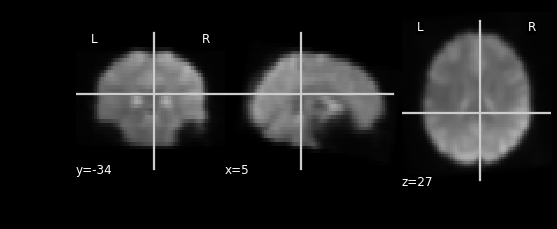

In [7]:
plotting.plot_anat(image.mean_img(fmri_img));

### Modell erstellen

In [8]:
fmri_glm = first_level_model.FirstLevelModel(t_r=3,period_cut=300)

In [11]:
fmri_glm = fmri_glm.fit(fmri_img, df)

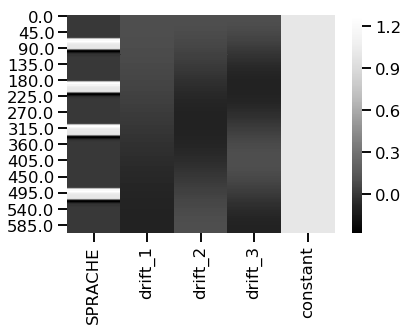

In [12]:
design_matrix = fmri_glm.design_matrices_[-1]
sns.heatmap(design_matrix,cmap='Greys_r');

### Whole-Brain PSC Image

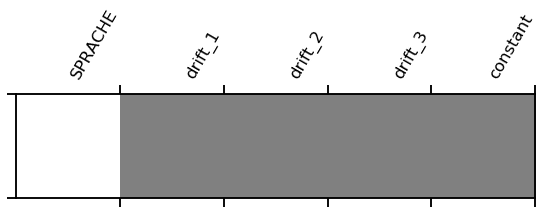

In [14]:
sprache = np.zeros(design_matrix.shape[1]); sprache[0] = 1
reporting.plot_contrast_matrix(sprache, design_matrix=design_matrix);

In [15]:
eff_img = fmri_glm.compute_contrast(sprache,output_type='effect_size')

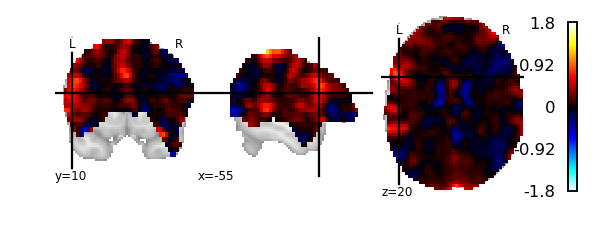

In [16]:
plotting.plot_stat_map(eff_img,cut_coords=(-55,10,20));

### Ein Beispielvoxel herauspicken

In [17]:
language_seed = (-55,10,20)
seed_masker = input_data.NiftiSpheresMasker(seeds=[language_seed],radius=1).fit()

In [ ]:
voxel_data = seed_masker.transform(fmri_img)

Der Signalverlauf in dem Voxel

In [21]:
voxel_data.ravel()

array([774., 774., 777., 777., 775., 782., 777., 779., 778., 776., 780.,
       784., 778., 779., 776., 774., 776., 772., 770., 767., 772., 781.,
       781., 776., 779., 776., 776., 779., 781., 782., 781., 780., 776.,
       772., 767., 776., 772., 772., 770., 770., 769., 771., 772., 770.,
       772., 776., 768., 766., 771., 770., 772., 778., 773., 774., 770.,
       773., 776., 769., 779., 779., 776., 781., 785., 786., 787., 779.,
       782., 780., 786., 785., 782., 782., 780., 780., 777., 780., 779.,
       782., 779., 777., 778., 786., 782., 770., 771., 778., 777., 774.,
       776., 779., 776., 777., 777., 779., 773., 773., 780., 777., 767.,
       771., 783., 781., 782., 787., 780., 777., 783., 788., 783., 786.,
       782., 787., 785., 783., 777., 785., 774., 770., 771., 770., 770.,
       779., 778., 771., 772., 777., 767., 771., 771., 775., 775., 779.,
       774., 777., 775., 778., 777., 776., 779., 775., 771., 776., 778.,
       770., 774., 780., 777., 776., 774., 773., 77

Das Beta in dem Voxel

In [ ]:
beta_data = seed_masker.transform(eff_img)[-1][-1]

In [23]:
beta_data

0.7069450176791965

### Die Gewichtung der Drifts modulieren

In [25]:
def make_plot(wSprache,wDrift1,wDrift2,wDrift3,wConstant):
    plt.plot(voxel_data)
    prediction1 = (design_matrix.loc[:,'SPRACHE']*wSprache).values
    prediction2 = (design_matrix.loc[:,'drift_1']*wDrift1).values
    prediction3 = (design_matrix.loc[:,'drift_2']*wDrift2).values
    prediction4 = (design_matrix.loc[:,'drift_3']*wDrift3).values
    prediction5 = (design_matrix.loc[:,'constant']*wConstant).values

    sum_of_predictions = prediction1 + prediction2 + prediction3 + prediction4 + prediction5
    plt.plot(sum_of_predictions,label='sum of preds')

    observed = voxel_data.ravel()
    predicted = sum_of_predictions.ravel()
    residual = ((observed-predicted)**2).sum()
    
    plt.title('sum of squared errors=%.2f'%residual)
    
    sns.despine(bottom=True,trim=True,offset=1)
    plt.legend(loc=(1,0.8))
    plt.show()

In [26]:
interact(make_plot,
         wSprache=(-20,20),
         wDrift1=(-20,20),
         wDrift2=(-20,20),
         wDrift3=(-20,20),
         wConstant=(740,790));

interactive(children=(IntSlider(value=0, description='wSprache', max=20, min=-20), IntSlider(value=0, descript…

### Bester Fit

In [27]:
def make_predict(voxel_data,design_matrix):
    my_model = regression.OLSModel(design_matrix)
    my_results = my_model.fit(voxel_data)
    this_predicted = my_results.predicted
    return this_predicted

In [28]:
this_predicted = make_predict(voxel_data,design_matrix)

In [29]:
def make_fig(voxel_data,this_predicted):
    plt.figure(figsize=(10,5))
    plt.plot(voxel_data,label='beobachtete Daten')
    plt.plot(this_predicted,label='bestes gefittete Modell')
    plt.xlabel('Zeitverlauf in TR')
    plt.ylabel('Rohes fMRT-Signal')
    plt.legend()
    sns.despine()
    plt.show()

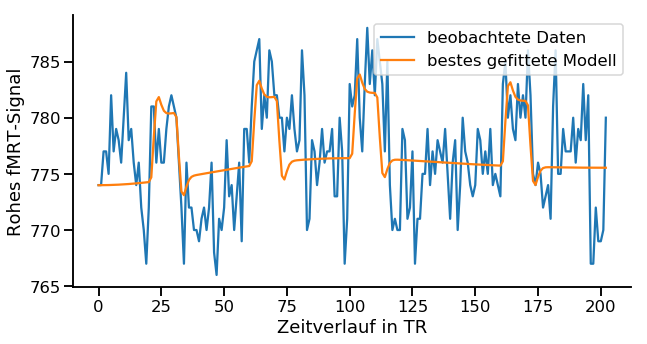

In [30]:
make_fig(voxel_data,this_predicted)

### Für verschieden liberale High-Pass Filter

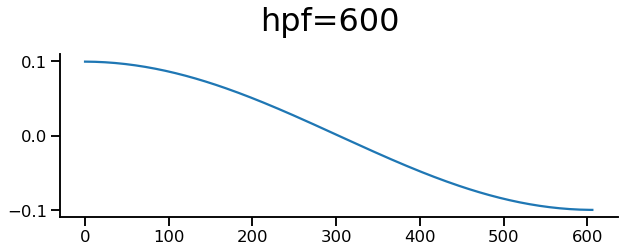

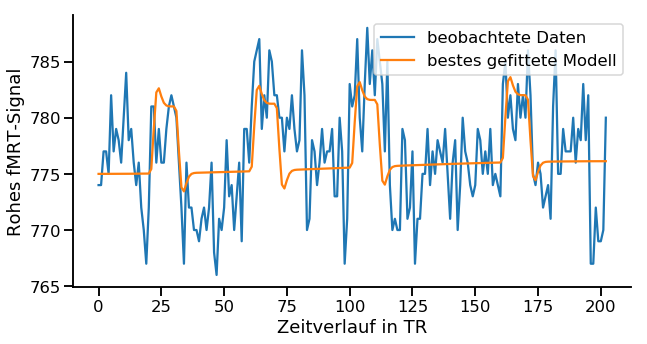

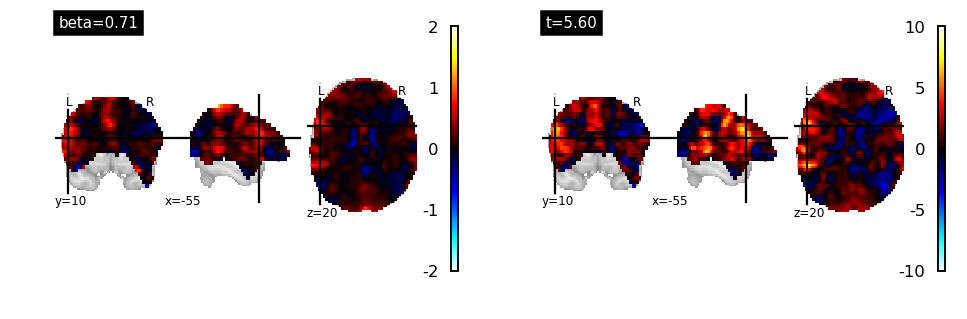

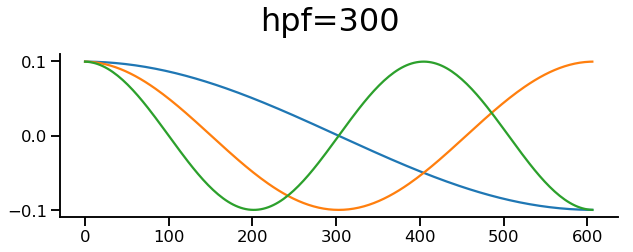

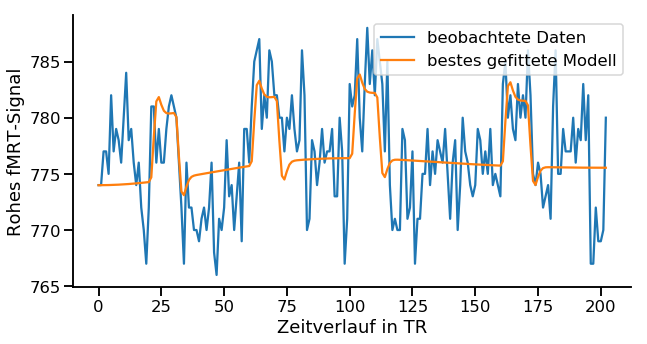

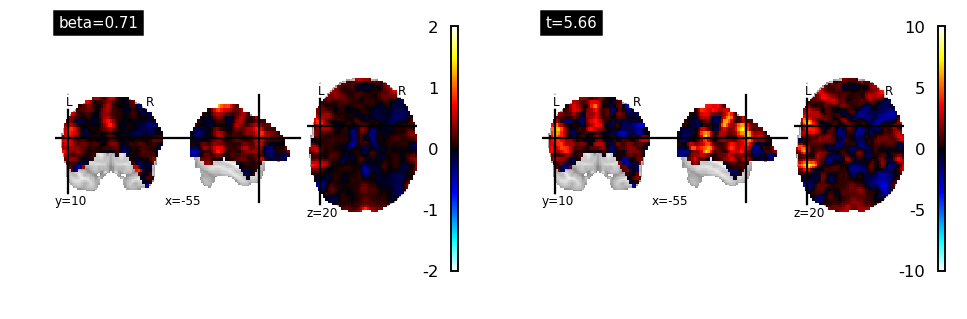

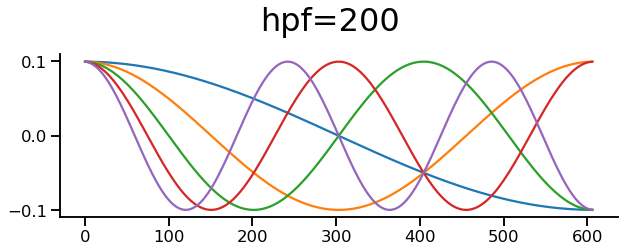

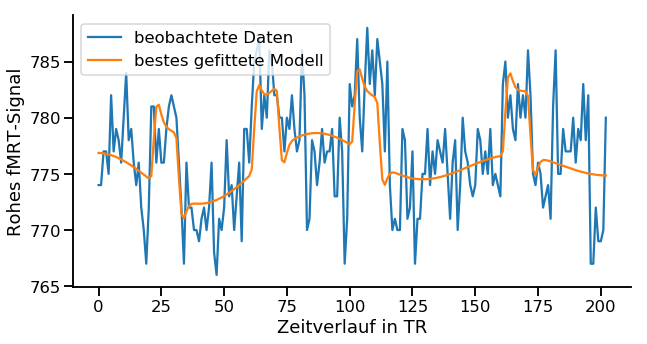

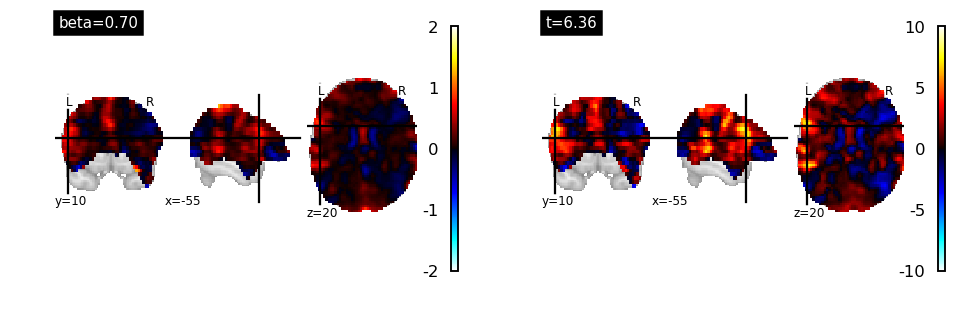

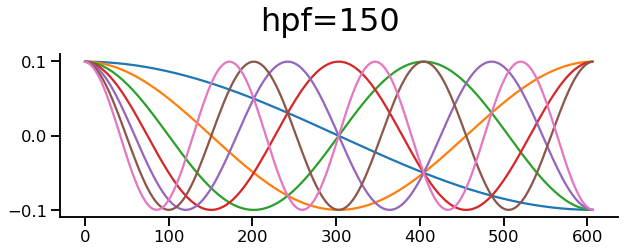

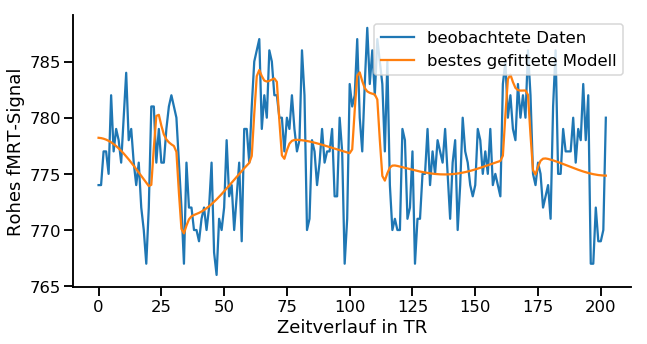

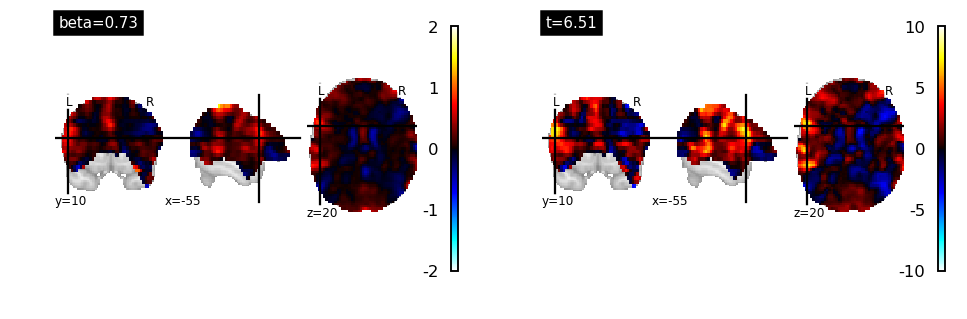

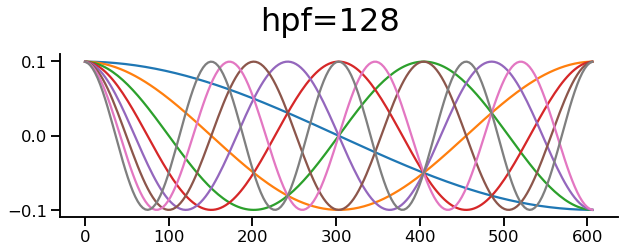

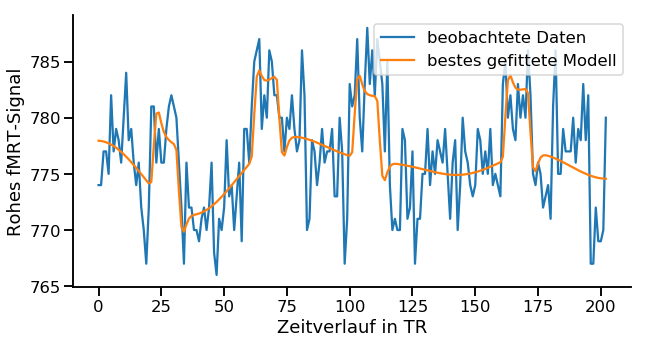

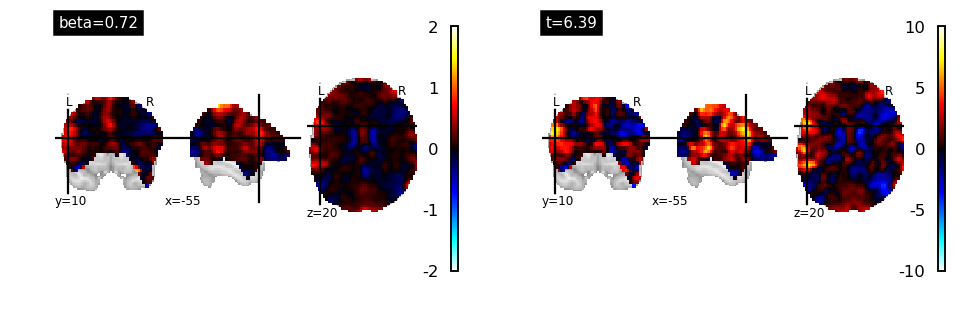

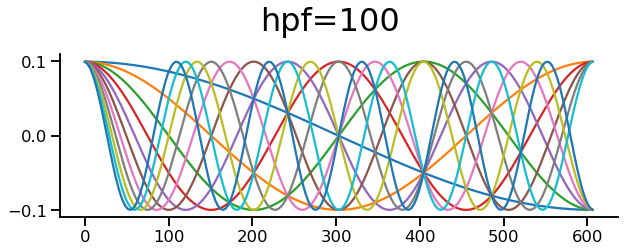

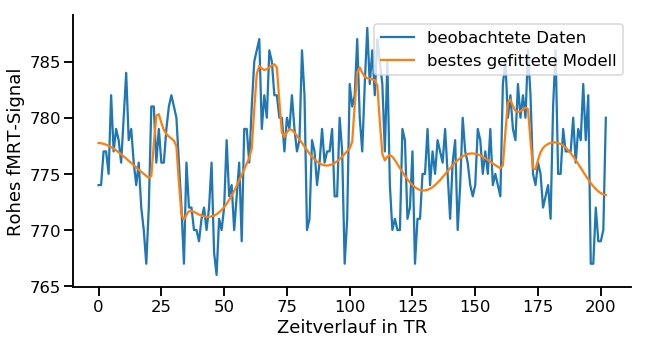

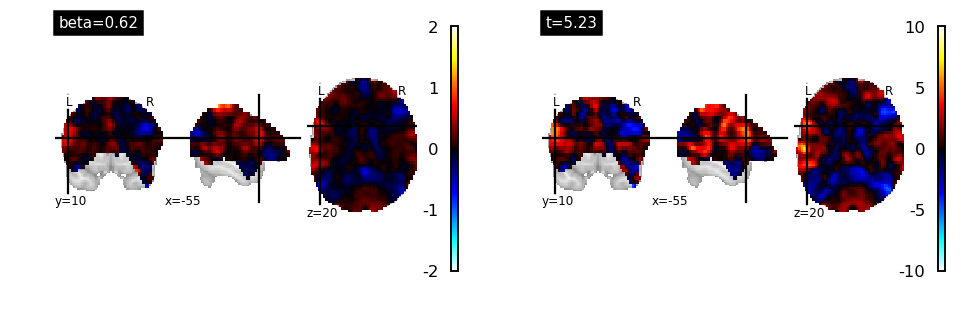

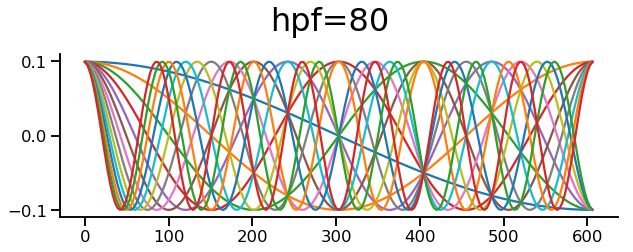

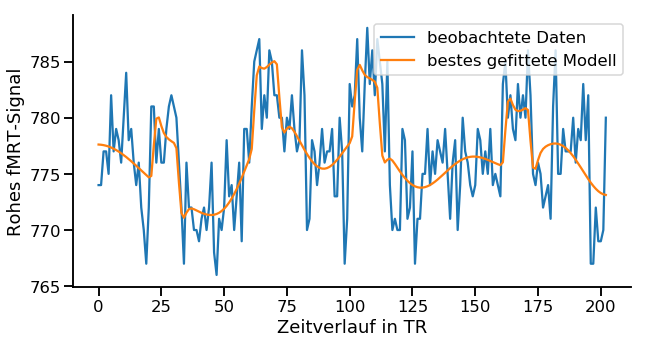

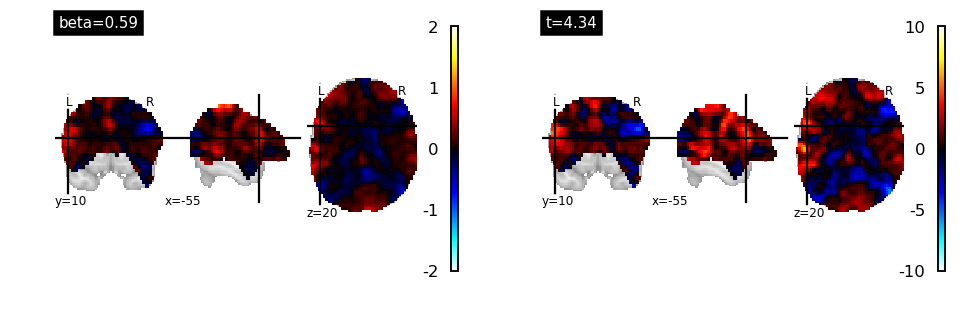

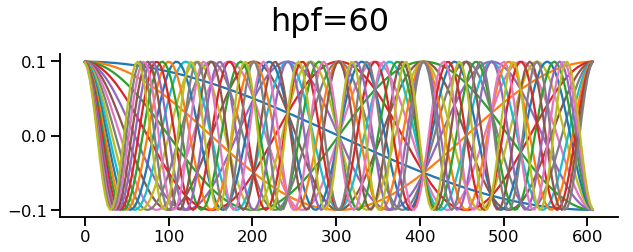

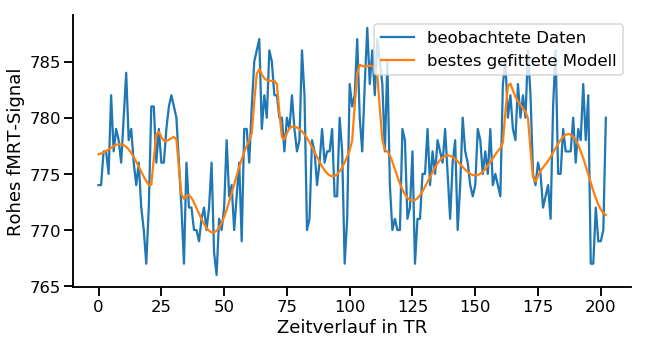

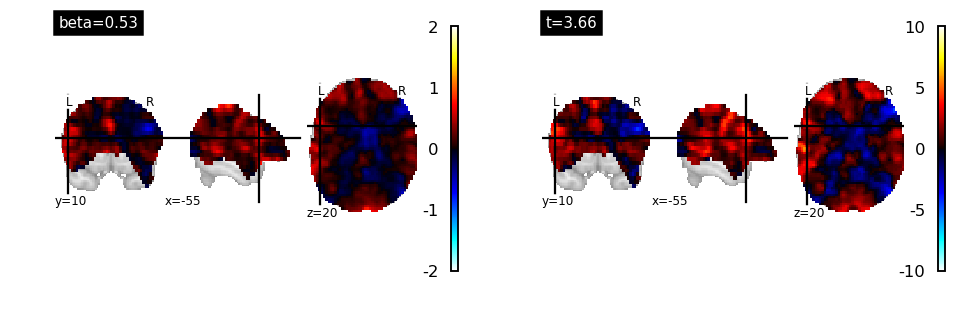

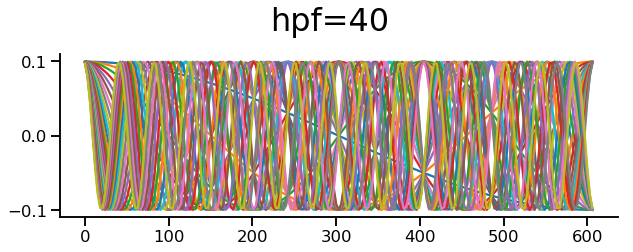

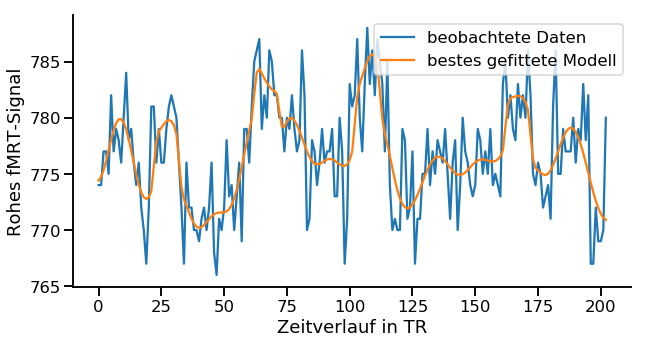

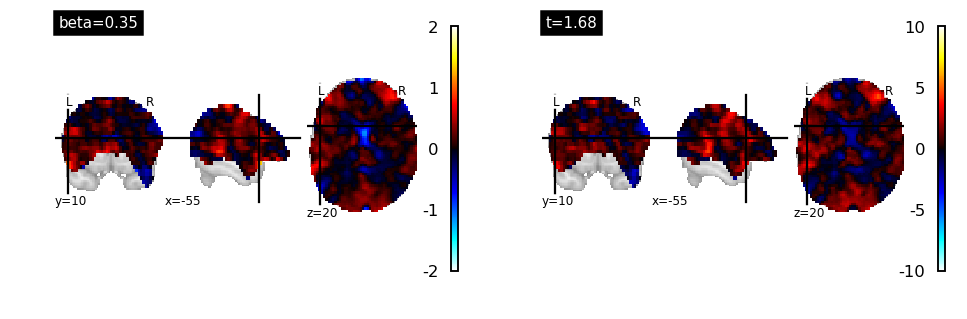

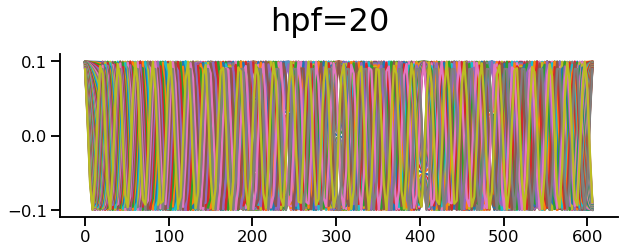

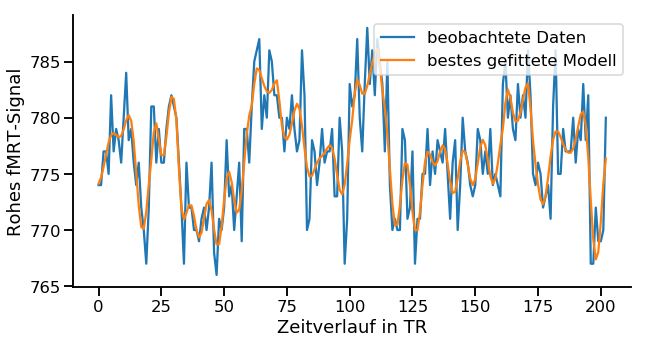

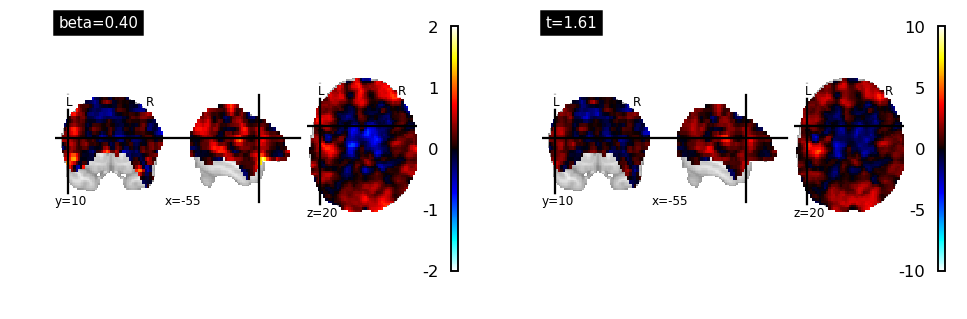

In [31]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    for this_cut in [600,300,200,150,128,100,80,60,40,20]:
        fmri_glm = first_level_model.FirstLevelModel(t_r=3,period_cut=this_cut).fit(fmri_img, df)
        design_matrix = fmri_glm.design_matrices_[-1]

        # show the drift regressors
        drift_matrix = design_matrix[[c for c in design_matrix.columns if c.startswith('drift')]]
        plt.figure(figsize=(10,3))
        plt.plot(drift_matrix)
        sns.despine()
        plt.suptitle('hpf=%s'%this_cut,fontsize=32,y=1.1)
        plt.show()

        # show the best fit
        this_predicted = make_predict(voxel_data,design_matrix)
        make_fig(voxel_data,this_predicted)

        # contrast
        sprache = np.zeros(design_matrix.shape[1]); sprache[0] = 1

        # beta image
        eff_img = fmri_glm.compute_contrast(sprache,output_type='effect_size')
        beta_data = seed_masker.transform(eff_img)[-1][-1]

        # t image
        t_img = fmri_glm.compute_contrast(sprache,output_type='stat')
        t_data = seed_masker.transform(t_img)[-1][-1]

        # plot brains
        fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
        plotting.plot_stat_map(eff_img,cut_coords=(-55,10,20),title='beta=%.2f'%beta_data,axes=ax1,vmax=2);
        plotting.plot_stat_map(t_img,cut_coords=(-55,10,20),title='t=%.2f'%t_data,axes=ax2,vmax=10);
        plt.show()

### Was wäre, wenn wir ein Modell hätten, das nur aus Drifts besteht?

In [32]:
empty_df = pd.DataFrame(columns=df.columns)
empty_df

Empty DataFrame
Columns: [onset, duration, trial_type, trial_subdomain, trial_content]
Index: []

In [34]:
fmri_glm = first_level_model.FirstLevelModel(t_r=3,period_cut=300)
fmri_glm = fmri_glm.fit(fmri_img, empty_df)

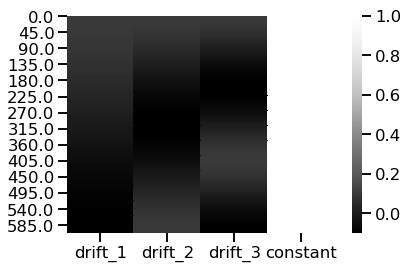

In [35]:
design_matrix = fmri_glm.design_matrices_[-1]
sns.heatmap(design_matrix,cmap='Greys_r');

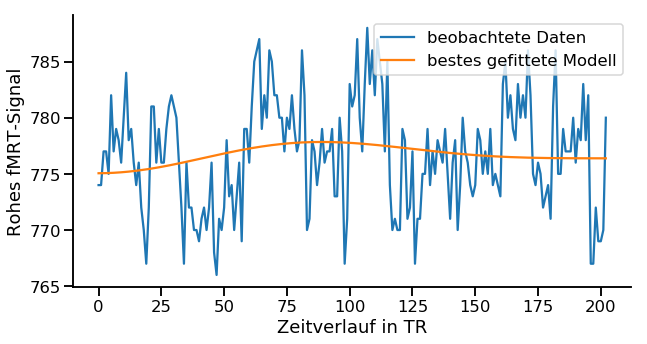

In [36]:
this_predicted = make_predict(voxel_data,design_matrix)
make_fig(voxel_data,this_predicted)

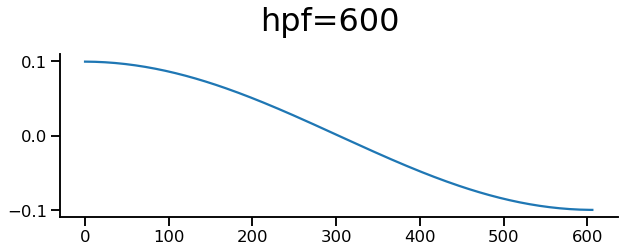

600


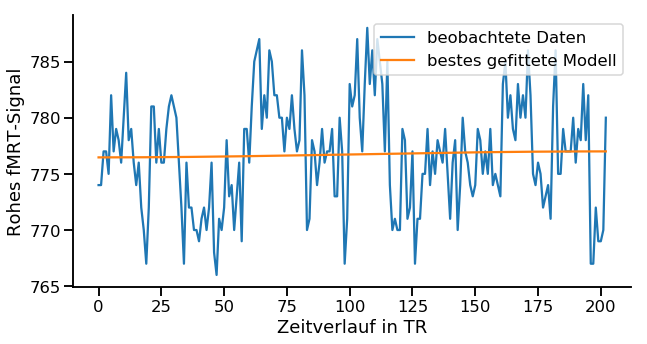

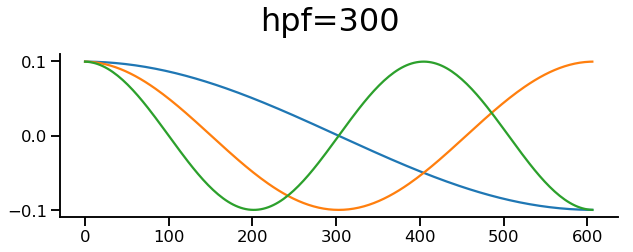

300


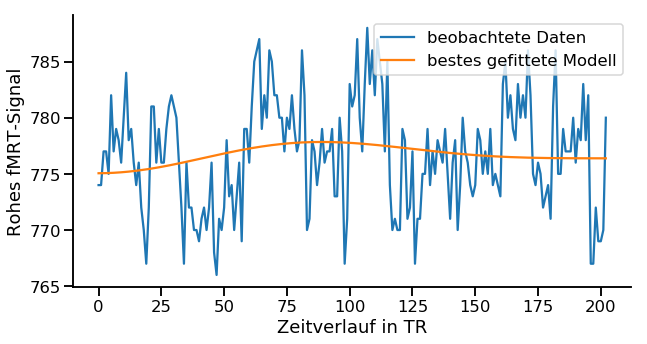

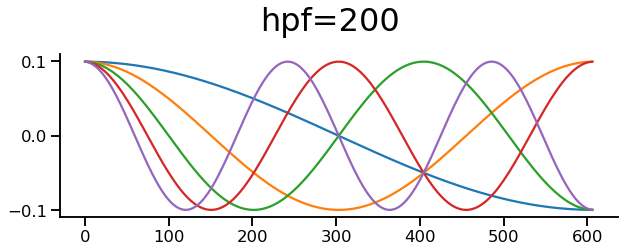

200


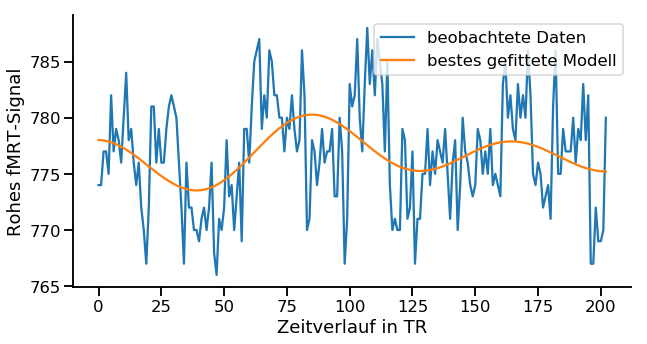

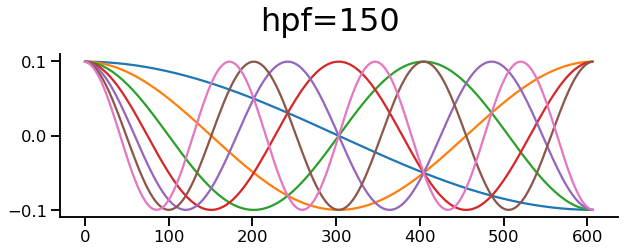

150


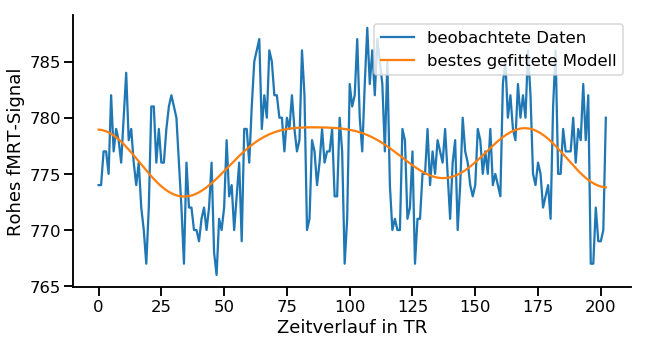

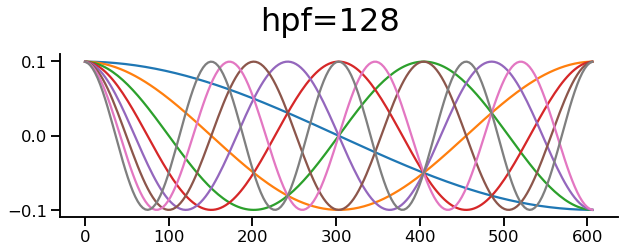

128


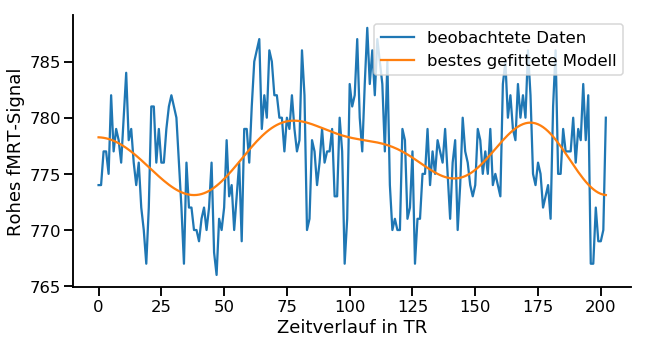

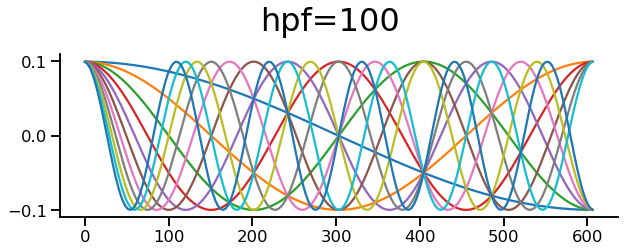

100


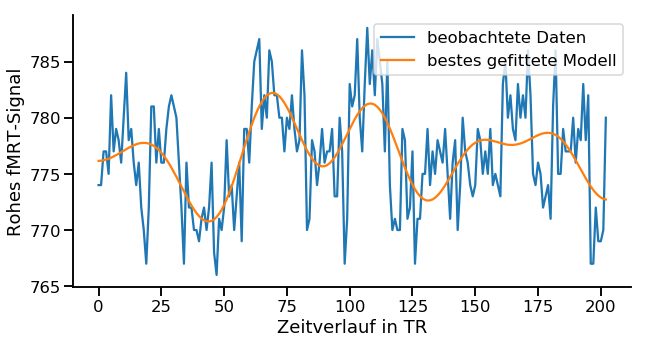

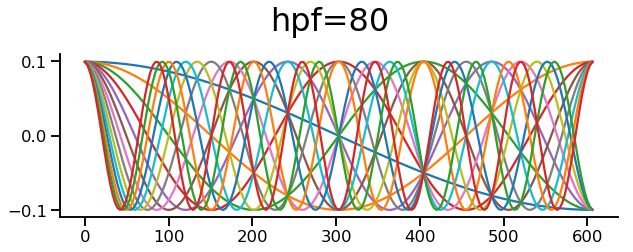

80


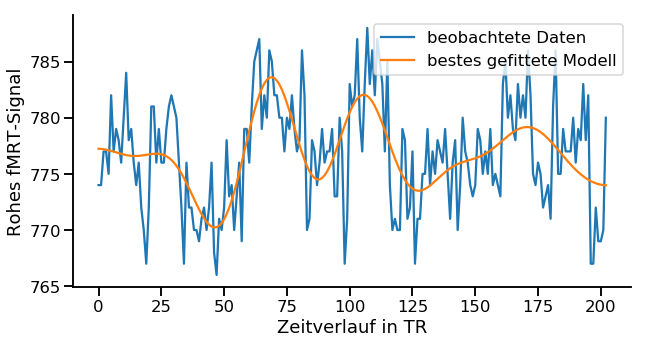

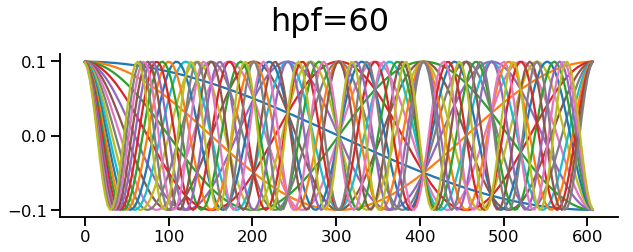

60


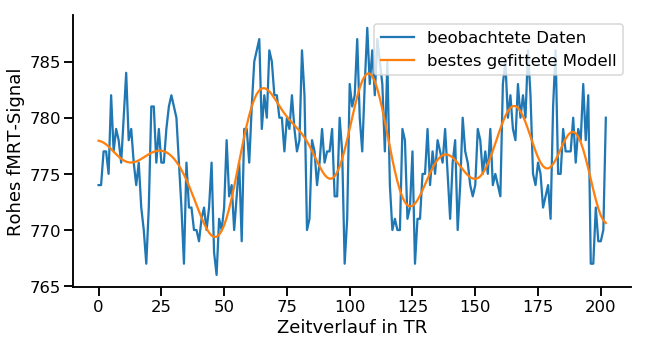

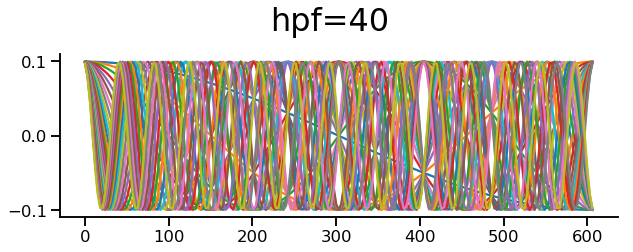

40


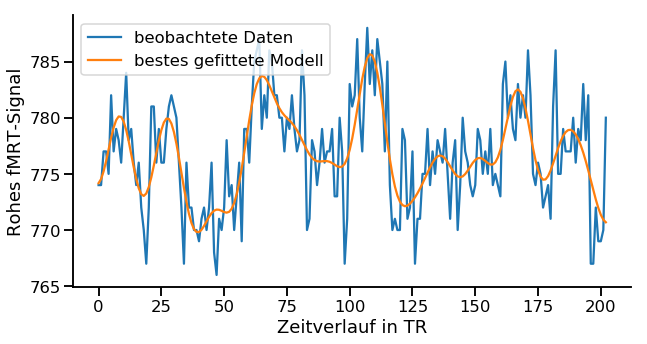

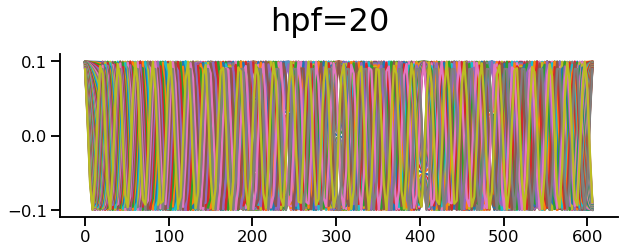

20


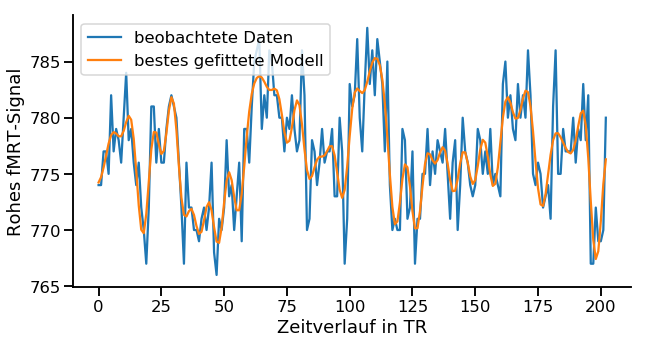

In [40]:
for this_cut in [600,300,200,150,128,100,80,60,40,20]:
    fmri_glm = first_level_model.FirstLevelModel(t_r=3,period_cut=this_cut).fit(fmri_img, empty_df)
    
    
    design_matrix = fmri_glm.design_matrices_[-1]

    # show the drift regressors
    drift_matrix = design_matrix[[c for c in design_matrix.columns if c.startswith('drift')]]
    plt.figure(figsize=(10,3))
    plt.plot(drift_matrix)
    sns.despine()
    plt.suptitle('hpf=%s'%this_cut,fontsize=32,y=1.1)
    plt.show()
    
    # show the best fit
    print(this_cut)
    this_predicted = make_predict(voxel_data,fmri_glm.design_matrices_[-1])
    make_fig(voxel_data,this_predicted)

Fazit: wenn wir hochfrequente Drifts zulassen, fressen sie uns die experimentelle induzierte Varianz auf. Der High-Pass-Filter Default von 128 kann für Designs mit vielen Bedingungen, so wie hier mit 5, schon recht niedrig sein, weil bei dieser Anzahl von Bedingungen die Blocks einer Bedingung zeitlich reicht weit auseinander liegen können und dann ein bisschen was von der experimentell induzierten Varianz rausgefiltert werden könnte.